In [6]:
from pyloco import loco_correction_lm, remove_bad_bpms, plot_data
import numpy as np
import at
ring = at.load_lattice('p3_low_beta.mat')
elements_ind = at.get_refpts(ring, "*")
_, _, twiss = at.get_optics(ring, elements_ind)
# ============================================================================== #
#                Prepare quadrupoles,skews, correctors, bpms, cavity indices
# ============================================================================== #

quad_indices = np.load('quad_ind.npy')
skew_ord = np.load('skew_ind.npy')

data = np.load('CMstep.npz')
CMstep = [data['hor'], data['ver']]

def load_names(filename):
    with open(filename, 'r') as file:
        names = [line.strip() for line in file.readlines()]
    return names

HCM_names = load_names("HCM_names.txt")
VCM_names = load_names("VCM_names.txt")
cor_ind_x = []
for i, elem in enumerate(ring):
    if getattr(elem, 'CommonName', None) in HCM_names:
        cor_ind_x.append(i)

cor_ind_y = []
for i, elem in enumerate(ring):
    if getattr(elem, 'CommonName', None) in VCM_names:
        cor_ind_y.append(i)

used_bpm = at.get_refpts(ring, at.elements.Monitor)


sorted_cor_ind_x = np.sort(cor_ind_x)
sorted_cor_ind_y = np.sort(cor_ind_y)
Corords = [sorted_cor_ind_x, sorted_cor_ind_y]
CAVords = at.get_refpts(ring, at.elements.RFCavity)

measured_orm =  np.load("measurement_matlab.npy")
measured_dispersion = np.load("measurement_matlab_eta.npy")
Noise_BPMx=  np.load("Noise_BPMx.npy")
Noise_BPMy =  np.load("Noise_BPMy.npy")

# ============================================================================== #
#               Remove bad BPMs from measurment data
# ============================================================================== #

bad_bpm_ind = [1973, 5639, 5681, 5825, 6011, 6087, 6197, 6297, 6311, 7641]
bad_bpm_positions = np.array([24, 104, 108, 111, 123, 138, 144, 153, 161,162, 243])
Noise_BPMx_cleaned = np.delete(Noise_BPMx, bad_bpm_positions)
Noise_BPMy_cleaned = np.delete(Noise_BPMy, bad_bpm_positions)
sigma_w = np.concatenate((Noise_BPMx_cleaned, Noise_BPMy_cleaned))[:, np.newaxis]  # Note: weight matrix shape for pyloco
used_bpms_ords = np.delete(used_bpm, bad_bpm_positions)


measured_orm , removed = remove_bad_bpms(measured_orm,
                                     bad_bpm_positions,
                                     total_bpms=246,
                                     axis=0,
                                     input_type="positions")

measured_eta , removed = remove_bad_bpms(measured_dispersion,
                                     bad_bpm_positions,
                                     total_bpms=246,
                                     axis=0,
                                     input_type="positions")

measured_eta_x = measured_eta[:235]
measured_eta_y = measured_eta[235:]



========== LOCO Iteration 1 / 1 LM Method ==========
Measuring ORM from simulation ...
Measuring ORM from simulation Done ...
Compute Jacopian ...
[calculate_quads_jacobian] Logs saved to '/Users/elafmusa/Desktop/PETRA III/quad_jacobian_logs.txt'
Compute Jacopian Done...
Fixedmomentum == True
Removing XY coupling from ORM and Jacobian and weight ...
   std(Model-Measurement) = 0.210708 mm (with outliers)
   No outliers in the data set.
Initial Chi^2 before inner loop: 2.4559e+04

========== Inner Iteration 1 / 10 – LM ==========
Performing SVD of weighted Jacobian ...

 SVD plots displayed ..


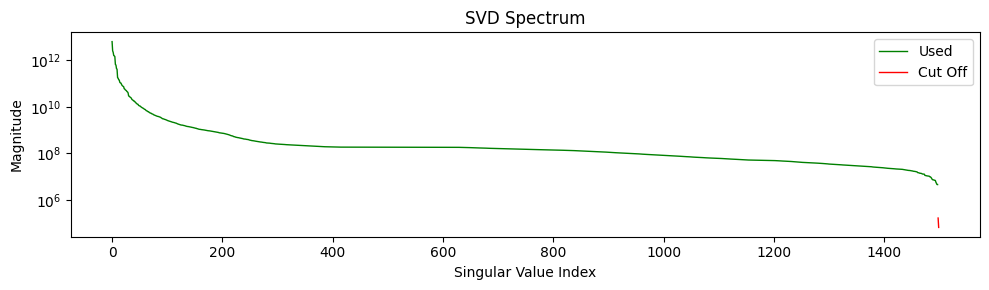

SVD retained: 1498 / 1500 singular values
Chi² after correction: 6.5528e+02 (previous: 2.4559e+04)
Chi² improved — reducing lambda
Computing chi-squared after correction ...
Chi-squared after correction: 655.278
LOCO LM Correction Completed! :)


In [7]:
import numpy as np

# --- define arguments  ---
nIter        = 1
nHorCOR      = len(Corords[0])
nVerCOR      = len(Corords[1])
nHBPM        = 235
nVBPM        = 235
cut_         = 397
fit_list     = [
    "quads",
    "hbpm_gain",
    "vbpm_gain",
    "hcor_cal",
    "vcor_cal",
    "HCMEnergyShift",
]
svd_method   = "threshold"
svd_thresh   = 1e-7

# --- run LOCO correction ---
fit_results, ring = loco_correction_lm(
    ring,
    used_bpms_ords=used_bpms_ords,
    used_cor_ords=Corords,
    CMstep=CMstep,
    nIter=nIter,
    nHorCOR=nHorCOR,
    nVerCOR=nVerCOR,
    nHBPM=nHBPM,
    nVBPM=nVBPM,
    orm_measured=measured_orm,
    cut_=cut_,
    weights=sigma_w,
    quads_ords=quad_indices,
    fit_list=fit_list,
    show_svd_plot=True,
    CAVords=CAVords,
    remove_coupling_=True,
    nLMIter=10,
    plot_fit_parameters=False,
    includeDispersion=False,
    outlier_rejection=True,
    measured_eta_x=measured_eta_x,
    measured_eta_y=measured_eta_y,
    sigma_outlier=10,
    svd_selection_method=svd_method,
    svd_threshold=svd_thresh,
    apply_normalization=True,
    normalization_mode="component",
    auto_correct_delta=True,
    fixedpathlength=False,
    individuals=True,
)

# --- save results ---
np.save("loco_lm_fit_results.npy", fit_results)

Lattice tune after loco : [0.11570526 0.29701634]


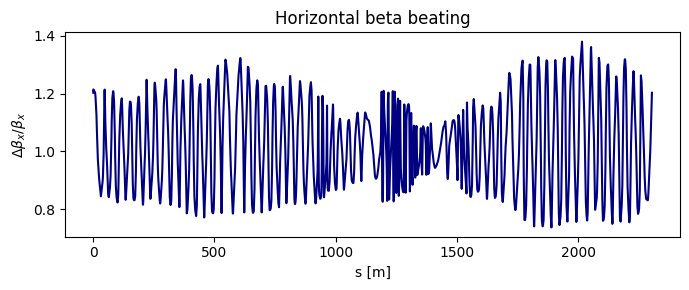

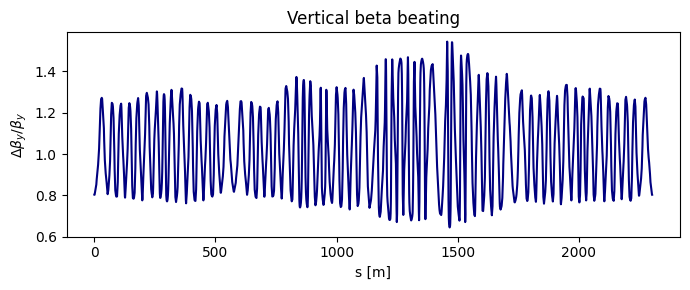

In [8]:
print('Lattice tune after loco :' , at.get_tune(ring))
_, _, twiss_err = at.get_optics(ring, elements_ind)
s_pos = twiss_err.s_pos
bx = (twiss_err.beta[:, 0]) / twiss.beta[:, 0]
by = (twiss_err.beta[:, 1]) / twiss.beta[:, 1]
plot_data(s_pos, bx, "s [m]", r"$\Delta\beta_x / \beta_x$ ", "Horizontal beta beating")
plot_data(s_pos, by, "s [m]", r"$\Delta\beta_y / \beta_y$ ", "Vertical beta beating")

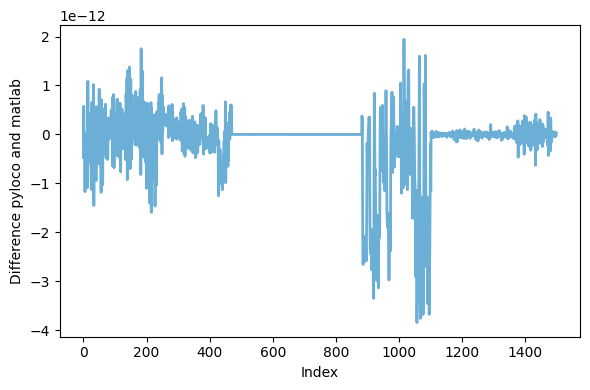

In [9]:
import matplotlib.pyplot as plt
fit_results_matlab = np.load('matlab_fit_1iter.npy')
rel_diff = (fit_results_matlab - fit_results)
plt.figure(figsize=(6, 4))
plt.plot(rel_diff, color="#6baed6", lw=2)
plt.xlabel("Index")
plt.ylabel("Difference pyloco and matlab")
plt.tight_layout()
plt.show()

In [3]:
from scipy.io import loadmat
bnew1_ = loadmat('b_new_p2_1.mat')
bnew_1 = bnew1_['b_new'].ravel()
import numpy as np

In [4]:
np.save('matlab_coupling_fit_1iter', bnew_1)